In [13]:
using Gen
using Distributions
using Random
using Plots

In [68]:
@gen function seir_model_complete(T::Int, N::Int)
    # Latent parameters with priors
    β ~ beta(2, 3)   # transmission probability
    σ ~ beta(2, 5)   # incubation rate
    γ ~ beta(2, 8)   # recovery rate

    # Initial states
    S = N - 1
    E = 1
    I = 0
    R = 0

    infected_counts = Int[]

    for t in 1:T
        # Probabilities
        infection_prob  = min(β * I / N, 1.0)
        incubation_prob = σ
        recovery_prob   = γ

        # Transitions using Binomial counts
        new_E = @trace(binom(S, infection_prob), (:new_E, t))
        new_I = @trace(binom(E, incubation_prob), (:new_I, t))
        new_R = @trace(binom(I, recovery_prob), (:new_R, t))

        # Update compartments
        S -= new_E
        E += new_E - new_I
        I += new_I - new_R
        R += new_R

        # Observation tied to infectious individuals
        obs = @trace(poisson(I), (:obs, t))
        push!(infected_counts, obs)

        @assert S + E + I + R == N  # sanity check
    end

    return infected_counts
end


DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Int64, Int64], false, Union{Nothing, Some{Any}}[nothing, nothing], Main.var"##seir_model_complete#310", Bool[0, 0], false)

In [69]:
Random.seed!(3)

T = 100
N = 100

(trace, _) = generate(seir_model_complete, (T, N))


println("Observations:")
println(get_retval(trace))

println("\nLatent parameters:")
println("β = ", trace[:β])
println("σ = ", trace[:σ])
println("γ = ", trace[:γ])


Observations:
[0, 1, 0, 1, 2, 2, 1, 1, 0, 2, 3, 4, 2, 5, 3, 2, 1, 0, 3, 0, 5, 2, 7, 5, 9, 15, 7, 10, 17, 14, 9, 9, 16, 16, 13, 26, 25, 40, 17, 16, 22, 25, 24, 19, 16, 20, 13, 15, 21, 21, 23, 17, 15, 17, 17, 9, 15, 13, 6, 8, 14, 7, 3, 5, 7, 2, 7, 2, 1, 2, 0, 4, 2, 2, 1, 2, 2, 2, 0, 3, 2, 0, 1, 2, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Latent parameters:
β = 0.1909294714026328
σ = 0.3958183562411021
γ = 0.11914297209756279


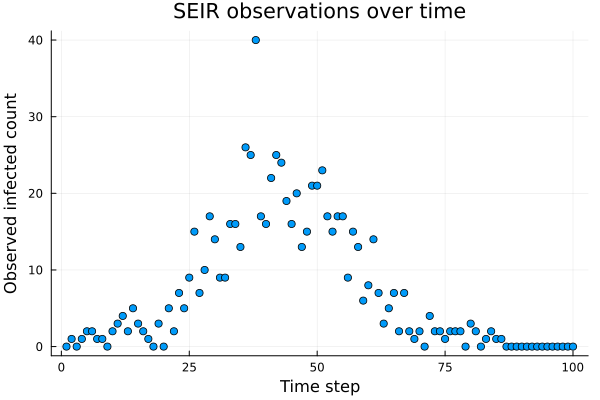

In [71]:
obs = get_retval(trace)

scatter(
    1:length(obs),
    obs,
    xlabel = "Time step",
    ylabel = "Observed infected count",
    title = "SEIR observations over time",
    legend = false
)
